In [1]:
# basic utility
import os, warnings
from glob import glob

# Data Preprocess 
import numpy as np
import pandas as pd

# Ploting tool
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib.colors import Normalize
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
sns.set(style="ticks", color_codes=True)

# Statistic utility
from scipy import stats
from scipy.stats import gaussian_kde

# scikit-learn alias
import sklearn.feature_selection as sk_fs
import sklearn.linear_model as sk_lm
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale, normalize
from sklearn.model_selection import (KFold, 
                                     GridSearchCV,
                                     cross_val_score, 
                                     cross_validate,
                                     train_test_split)
from sklearn.exceptions import ConvergenceWarning
# xgboost
import xgboost as xgb
from xgboost import plot_importance

# ignore warnings
warnings.filterwarnings("ignore", 
                        category=ConvergenceWarning)
warnings.simplefilter(action='ignore', 
                      category=FutureWarning)

This script will load some csv file for prediction process

1. newmp_wt_p.csv with column [Species, MolecularWeight(wt)]
2. newmp_p.csv with column [Index, Species, MeltingPoint(mp), ...]
                        others columns are Feature Name i,..., n
3. dnscan_clusteringlabels.csv which is Classification labels 
    for all compounds. That is, labels[n] = The classification 
    label value of the n-th compound.
    Which is created by the following code
    ...
    db = DBSCAN(eps=3, min_samples=30).fit(Xss_thres_002)
    labels = db.labels_
    pd.DataFrame(labels).to_csv('dnscan_clusteringlabels.csv')


In [2]:
%%time
dataFolder = "./data"
resultsFolder = "./results"
print("Loading data...", end=" ")
df_wt = pd.read_csv(os.path.join(dataFolder, 
                        'newmp_wt_p.csv'), 
                    header=None) # 'join' is used to fit all the OS.
df_mp = pd.read_csv(os.path.join(dataFolder, 
                        'newmp_p.csv'))
df_labels = pd.read_csv(os.path.join(dataFolder, 
                        'dnscan_clusteringlabels.csv'))
print("Done!")

Loading data... Done!
Wall time: 8.11 s


In [3]:
# Tips:  In a dataframe, 
# the column is for a vertical view from top to bottom
# The row is for a horizontal view from left to right.
# A dataframe is composed from lots of 'Series'.
# Each series is a column, and the name is defined in header.
# Hence, if we only using Features in df_mp, we will use this line
featName = df_mp.columns[3:]

n_clusters_: 17 n_noise_: 9544


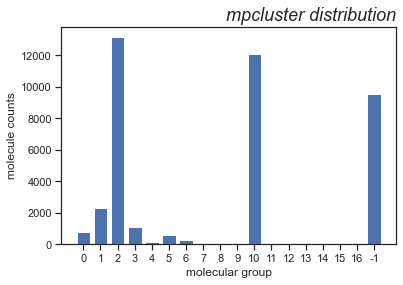

Save labels_distribution.png


In [4]:
labels = df_labels.iloc[:,1].values # Get labels without index
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
print("n_clusters_:", n_clusters_, "n_noise_:", n_noise_)
plt.bar(np.arange(len(set(labels))),[sum(labels==i) for i in set(labels)])
plt.xticks(np.arange(len(set(labels))),set(labels))
plt.xlabel('molecular group'); plt.ylabel('molecule counts')
#plt.xticks(np.arange(-10,210, 10))
plt.title('mpcluster distribution', loc='right',style='italic',fontsize=18)
plt.savefig('./results/img/labels_distribution.png')
# plt.close()
plt.show()
print("Save labels_distribution.png")

# Data cleaning and preprocessing

In [5]:
df_mp_dropna = df_mp.dropna(axis=0) # remove NaN data
# removing index = 14843
df_mp_dropna = df_mp_dropna.drop(index=14843, axis=0)
#Get the wt which is index in df_mp_dropna
df_wt_from_mp_dropna = df_wt.loc[df_mp_dropna.index]
# # Concatenate some data
parseddata = pd.concat([df_mp_dropna.iloc[:,1:3],
                        df_wt_from_mp_dropna.iloc[:,1],
                        pd.Series(labels, index=df_mp_dropna.index)],
                    axis=1)
# Export csv for parseddata
parseddata.to_csv(os.path.join(resultsFolder, 'parseddata.csv'), 
                    index=False)

# Task1: Prediction All Classification

In [6]:
%%time
# ============= Task1: Prediction All Classification =============
print("Task1: Prediction All Classification")
X = df_mp_dropna.iloc[:,3:]# Get the Feature columns
Y = df_mp_dropna.iloc[:,2] # Get the mp column, i.e., one series
VTS_thres_002 = sk_fs.VarianceThreshold(threshold=0.02)
X_vts_thres_002 = VTS_thres_002.fit_transform(X)
featNameVTS_thres_002 = featName[VTS_thres_002.get_support()]
Xss_thres_002 = scale(X_vts_thres_002, axis=1)
# ============= Experiment: K-Fold Cross Validation =============
# With K = 10
print("Experiment: K-Fold Cross Validation with XGBRegressor")
"""
max_depth(): the depth of tree
n_estimator(): the numbers of tree
colsample_bytree(): Control the proportion of each randomly
                    sampled column (Each column is a feature)
"""
kfold = KFold(n_splits=10, random_state=7, shuffle=True)
model_with_kfold = xgb.XGBRegressor(max_depth=6,
                        learning_rate=0.03,
                        n_estimators=500,
                        silent=True,
                        objective='reg:squarederror',
                        reg_lambda=0.5,
                        reg_alpha=0 )
allResult = cross_val_score(model_with_kfold, 
                            Xss_thres_002, Y, cv=kfold)
# Export the results for XGBRegressor
pd.DataFrame(allResult).to_csv(os.path.join(resultsFolder, 
                                'allnewmp_cvresult.csv'),
                                index=False)
print("Done!")
# ========== End of Experiment: K-Fold Cross Validation ==========

Task1: Prediction All Classification


C:\Users\ziyu_desktop\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\_data.py:174: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


Experiment: K-Fold Cross Validation with XGBRegressor
[00:12:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:21:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:30:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate 

# Experiment: Self-Randomly Sample Dataset

In [7]:
# ========== Experiment: Self-Randomly Sample Dataset ============
# Split the data into Train, Validation, Test set
print("Experiment: Self-Randomly Sample Dataset with XGBRegressor")
X_train, X_test, y_train, y_test = train_test_split(Xss_thres_002, Y,
                                    test_size=0.1,random_state=123)
model_with_Self_Split = xgb.XGBRegressor(max_depth=6,
                        learning_rate=0.03,
                        n_estimators=500,
                        silent=True,
                        objective='reg:squarederror',
                        reg_lambda=0.5,
                        reg_alpha=0 )
train_xgb = model_with_Self_Split.fit(X_train, y_train)
train_xgbscore = train_xgb.score(X_train, y_train)
test_xgbscore = train_xgb.score(X_test, y_test)
xgbr_pred_Y = train_xgb.predict(Xss_thres_002)
xgbr_pred_Ytest = train_xgb.predict(X_test)

r2_score_TrainSet = r2_score(Y.values, xgbr_pred_Y)
cmap = cm.rainbow(np.linspace(0.0, 1.0, n_clusters_ ))

Experiment: Self-Randomly Sample Dataset with XGBRegressor
[01:46:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




C:\Users\ziyu_desktop\Anaconda3\envs\tf\lib\site-packages\xgboost\data.py:115: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")


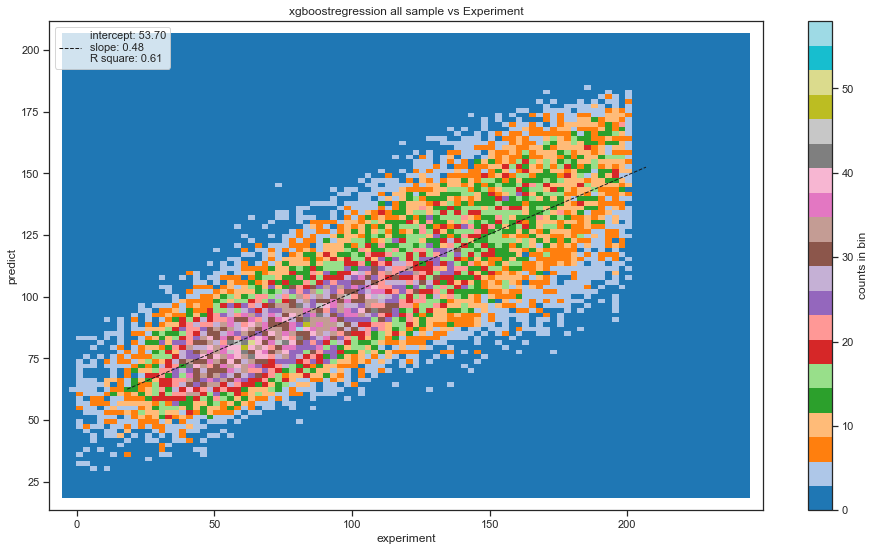

Save Experiment_xgboostregression_all_sample.png


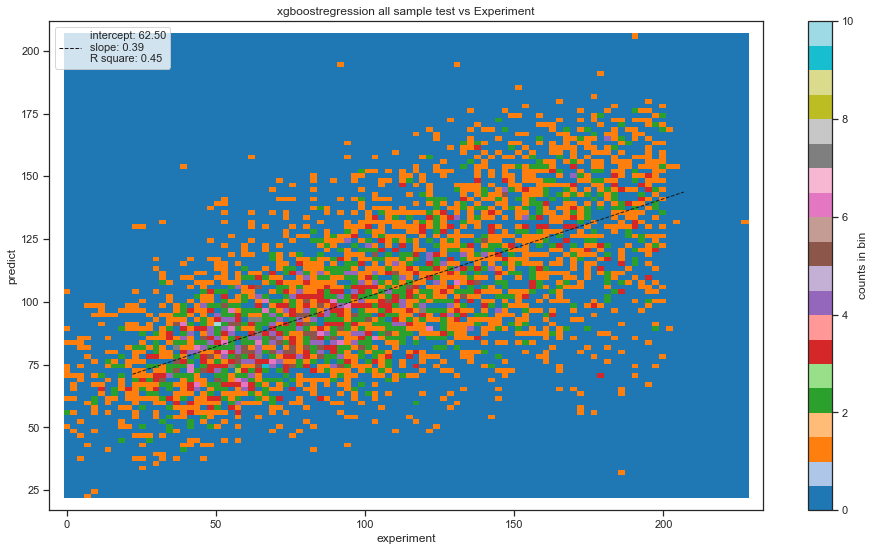

Save Experiment_xgboostregression_all_sample_test.png
MAE of Y      = 24.968244452191296
MAE of Y_test = 28.92511541730039
Done!


In [8]:

def regressiondensityplot(X, Y, title, num_bins, 
                          cmap='tab20',
                         ):
    '''
    @parameter
    X: (Array) Training data with shape (n_samples, n_features)
    Y: (Array) Target values  with shape (n_samples,) 
        or (n_samples, n_targets)
    title: (String) The title of figure
    cmap: (String) The color map name for using, which you can
        find in following url
    https://matplotlib.org/1.2.1/mpl_examples/pylab_examples/show_colormaps.pdf
    '''
    estimator = sk_lm.LinearRegression() # Initial the regression model
    plotmod = estimator.fit(X.reshape(-1,1), Y.reshape(-1,1))
    plotmodR2 = plotmod.score(X.reshape(-1,1), Y.reshape(-1,1))
    x,y = X,Y
    xy = np.vstack([x, y])
    z = gaussian_kde(xy)(xy)
    # Sort the points by density, 
    # so that the densest points are plotted last
    idx = z.argsort()
    norm = Normalize(vmin = np.min(z), vmax = np.max(z))
    x, y, z = x[idx], y[idx], z[idx]
    plt.figure(figsize=(16, 9))
    plt.hist2d(x, y,bins=num_bins,cmap=cmap)
    plt.xlim(X.min()-5,X.max()+5)
    plt.ylim(Y.min()-5, Y.max()+5)
    cb = plt.colorbar()
    cb.set_label('counts in bin')
    y_min = plotmod.predict(Y.min().reshape(-1,1))
    y_max = plotmod.predict(Y.max().reshape(-1,1))
    xminmax = [Y.min(),Y.max()]
    yminmax = [y_min[0], y_max[0]]
    plt.plot(xminmax, yminmax, linestyle='dashed',lw=1,color='k')
    intercept, slope = plotmod.intercept_, plotmod.coef_[0]
    leg_text = 'intercept: %.2f\nslope: %.2f\nR square: %.2f'%(
                intercept,          slope,          plotmodR2)
    plt.legend([leg_text], loc='upper left')
    plt.title('%s vs Experiment' %title)
    plt.xlabel('experiment')
    plt.ylabel('predict')
    title = title.replace(" ", "_")
    plt.savefig(f'./results/img/Experiment_{title}.png')
    plt.show()
    plt.close()
    print(f"Save Experiment_{title}.png")
regressiondensityplot(Y.values, xgbr_pred_Y, 
                        'xgboostregression all sample', 
                        100)
regressiondensityplot(y_test.values,xgbr_pred_Ytest,
                        'xgboostregression all sample test',
                        100)
print("MAE of Y      =", mae(Y.values,xgbr_pred_Y))
print("MAE of Y_test =", mae(y_test.values,xgbr_pred_Ytest))
print("Done!")
# ========== End of Task1: Prediction All Classification =========

# Task2: Prediction Classification 10

Experiment: Self-Randomly Sample Dataset with XGBRegressor


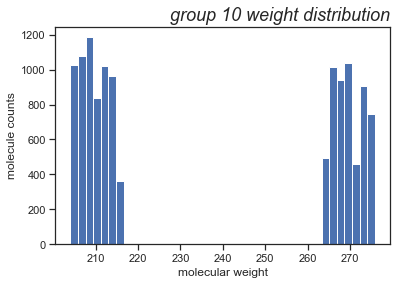

In [9]:
# ============= Task2: Prediction Classification 10  =============
print("Experiment: Self-Randomly Sample Dataset with XGBRegressor")
df_mp_class_10 = df_mp_dropna.loc[labels==10]
df_wt_class_10 = df_wt_from_mp_dropna.loc[labels==10]

# df_mp_class_10.to_csv(os.path.join(resultsFolder, 
#                     'newmp_group10.csv'))
X_class_10 = df_mp_class_10.iloc[:,3:]
Y_class_10 = df_mp_class_10.iloc[:,2]
VTS_thres_001 = sk_fs.VarianceThreshold(threshold=0.01)
X10_thres_001 = VTS_thres_001.fit_transform(X_class_10)
featnamevts = featName[VTS_thres_001.get_support()]
Xss10 = scale(X10_thres_001, axis=1)

# # For df_wt_class_10, unmarked this part to plot
plt.hist(df_wt_class_10.iloc[:,1], bins= 40)
plt.xlabel('molecular weight'); plt.ylabel('molecule counts')
#plt.xticks(np.arange(-10,210, 10))
plt.title('group 10 weight distribution', 
          loc='right',style='italic',fontsize=18)
plt.savefig('./results/img/group_10_weight_distribution.png')

# Experiment: Simple LinearRegression

In [10]:
%%time
# ============= Experiment: Simple LinearRegression =============
"""
Ordinary least squares Linear Regression.
LinearRegression fits a linear model with coefficients w = (w1, …, wp) 
to minimize the residual sum of squares between the observed targets 
in the dataset, and the targets predicted by the linear approximation.
"""
estimator = sk_lm.LinearRegression()
lr10mod = estimator.fit(Xss10, Y_class_10)
lr10s = lr10mod.score(Xss10, Y_class_10)
lr10p = lr10mod.predict(Xss10)
print(f"Score of Simple LinearRegression : {lr10s:.2f}")
# ========== End of Experiment: Simple LinearRegression ==========

Score of Simple LinearRegression : 0.65
Wall time: 384 ms


# Experiment: LassoCV

In [11]:
%%time
# ========== Experiment: LassoCV                      ============
"""
Lasso linear model with iterative fitting along a regularization path.
The best model is selected by cross-validation.
The optimization objective for Lasso is:
    (1 / (2 * n_samples)) * ||y - Xw||^2_2 + alpha * ||w||_1

Moreover, thouth maybe illogic, but we use this results with 
RandomForestRegressor to get a prediction for those feature is 
selected by the LassoCV.
"""
Xnl10 = normalize(X10_thres_001, axis=1)
reg = sk_lm.LassoCV(cv=5, random_state=1).fit(Xnl10, Y_class_10)
print("The score of LassoCV", reg.score(Xnl10, Y_class_10))
regcoef = abs(reg.coef_).argsort()[::-1]
idx = regcoef[:sum(abs(reg.coef_)>0)]
featnamelas = featnamevts[idx]
X_train, X_test, y_train, y_test = train_test_split(Xnl10[:, idx], 
                                    Y_class_10,
                                    test_size=0.2,
                                    random_state=123)
print("Start to fit RandomForestRegressor for feature")
regr = RandomForestRegressor(max_depth=20,
                            random_state=2,
                            n_estimators=200,
                            oob_score=True,
                            min_samples_split=2,
                            min_samples_leaf=1)
trainRFmod = regr.fit(X_train,y_train)
trainscore = trainRFmod.score(X_train, y_train)
testscore = trainRFmod.score(X_test, y_test)
regrY = trainRFmod.predict(Xnl10[:,idx])
regrmae = mae(Y_class_10.values, regrY)
err = abs(regrY - Y_class_10.values)
print("MAE for RandomForestRegressor Prediction class-10", regrmae)

The score of LassoCV 0.47136695882481194
Start to fit RandomForestRegressor for feature
MAE for RandomForestRegressor Prediction class-10 12.66496228956902
Wall time: 1min 3s


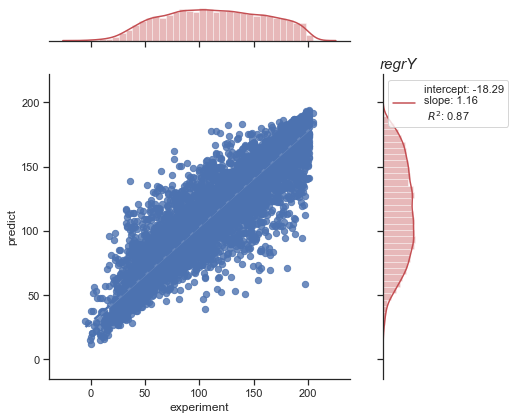

Save Experiment_regrY.png
Done!


In [12]:
def plot(X,Y,title):
    data=pd.DataFrame()
    data['experiment'] = X; data['predict'] = Y
    g = sns.JointGrid(x='experiment', y='predict', 
                        data=data, space=1)
    g = g.plot_marginals(sns.distplot, color="r", 
                        axlabel='wavelength distribution')
    g = g.plot_joint(sns.regplot,
                    scatter_kws={"s": 40},
                    line_kws={"color" : "b","linestyle":'--'})
    plotmod = estimator.fit(Y.reshape(-1,1), X.reshape(-1,1))
    plotmodR2 = plotmod.score(Y.reshape(-1,1), X.reshape(-1,1))
    intercept, slope = plotmod.intercept_, plotmod.coef_[0]
    leg_text = 'intercept: %.2f\nslope: %.2f\n $R^2$: %.2f'%(
                intercept,       slope,         plotmodR2)
    plt.legend([leg_text], loc='upper left')
    plt.title(title,loc='right',
                    style='italic',
                    fontsize=15)
    title = title.replace(" ", "_")
    plt.savefig(f'./results/img/R_square_{title}.png')
    plt.show()
    plt.close()
    print(f"Save Experiment_{title}.png")
plot(Y_class_10.values, regrY,'regrY')
print("Done!")
# ========== End of Experiment: LassoCV               ============

# Others Analysis and choose model

## PCA analysis for DBSCAN Label

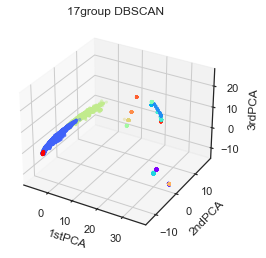

Save PCA_for_DBSCAN_Labels.png


In [13]:
pca3=PCA(n_components=3)
Xpcaed3=pca3.fit_transform(Xss_thres_002)

cmap = cm.rainbow(np.linspace(0.0, 1.0,n_clusters_ ))
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

plt.title('%sgroup DBSCAN' % n_clusters_)
plt.xlabel('1stPCA'); plt.ylabel('2ndPCA')
ax.set_zlabel('3rdPCA')
for i in range(0,n_clusters_):
    ax.scatter(Xpcaed3[labels==i,0], 
               Xpcaed3[labels==i,1], 
               Xpcaed3[labels==i,2], s=5,color=cmap[i])

plt.savefig(f'./results/img/PCA_for_DBSCAN_Labels.png')
plt.show()
#plt.close()
print(f"Save PCA_for_DBSCAN_Labels.png")

## Average Score of 10 Cross Validation

In [14]:
%%time
g10RFcv = cross_validate(regr,
                         Xnl10[:,regcoef[:sum(abs(reg.coef_)>0)]],
                         Y_class_10, 
                         cv=10,
                         return_train_score=True)
print(f"Score for g10RFcv: {np.mean(g10RFcv['test_score']):.2f}")

Score for g10RFcv: 0.44
Wall time: 10min 6s


## Using different random_state for model

In [15]:
%%time
# choose random state i = 384
X_train, X_test, y_train, y_test = train_test_split(
    Xnl10[:,regcoef[:sum(abs(reg.coef_)>0)]],
    Y_class_10, test_size=0.1, random_state=384)
model = xgb.XGBRegressor(max_depth=6,
                        learning_rate=0.03,
                        n_estimators=500,
                        silent=True,
                        objective='reg:squarederror',
                        reg_lambda=0.5,
                        reg_alpha=0 )
model.fit(X_train, y_train)
ans = model.predict(Xnl10[:,regcoef[:sum(abs(reg.coef_)>0)]])
trainans = model.predict(X_train)
testans  = model.predict(X_test)
ytranans = pd.concat([y_train,
                    pd.Series(trainans, index=y_train.index)],
                    axis=1)
ytranans.to_csv('./results/xgboost_y_train_predict.csv')
ytestans=pd.concat([y_test,
                    pd.Series(testans, index=y_test.index)],
                    axis=1)
ytestans.to_csv('./results/xgboost_y_test_predict.csv')


[02:07:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Wall time: 9.95 s


C:\Users\ziyu_desktop\Anaconda3\envs\tf\lib\site-packages\xgboost\data.py:115: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")


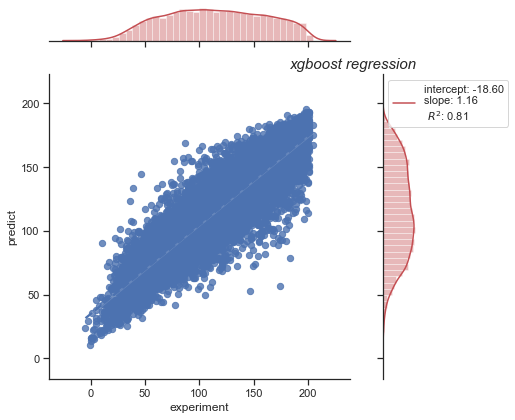

Save Experiment_xgboost_regression.png
r2_score of y_test 0.60128
r2_score of y_train 0.81449
mae of y_test 22.96
mae of y_train 15.52


In [16]:
plot( Y_class_10.values, ans, 'xgboost regression')
print(f"r2_score of y_test {r2_score(y_test,testans):.5f}")
print(f"r2_score of y_train {r2_score(y_train,trainans):.5f}")
print(f"mae of y_test {mae(y_test,testans):.2f}")
print(f"mae of y_train {mae(y_train,trainans):.2f}")

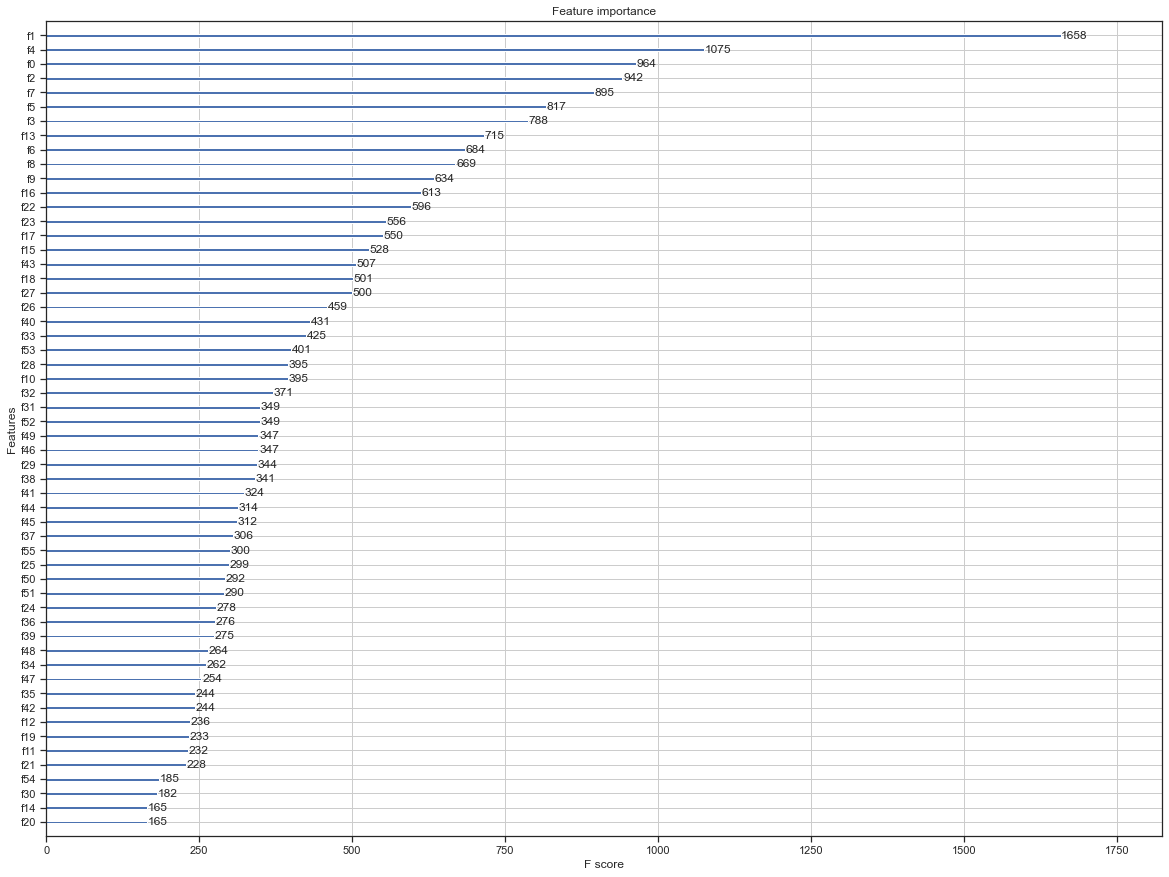

In [17]:
fig, ax = plt.subplots(figsize=(20,15))
plot_importance(model, ax=ax)
plt.savefig(f'./results/img/plot_importance.png')
# plt.close()

In [18]:
%%time
kfold = KFold(n_splits=10, random_state=7,shuffle=True)
results = cross_val_score(model, 
                        Xnl10[:,regcoef[:sum(abs(reg.coef_)>0)]],
                        Y_class_10, cv=kfold)
print("Average of KFold results for model_384:", np.mean(results))
#0.5600547026020155


imp_vals = model.get_booster().get_fscore()
imp_dict = {featnamelas[i]:float(imp_vals.get('f'+str(i),0.)) \
            for i in range(len(featnamelas))}
total = sum(list(imp_dict.values()))
importance={k:v/total for k,v in imp_dict.items()}
keys = list(importance.keys())
values = list(importance.values())
pd.concat([pd.Series(keys),
           pd.Series(values)],
          axis=1).to_csv('./results/featureimportance.csv')

[02:07:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:07:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:07:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindi

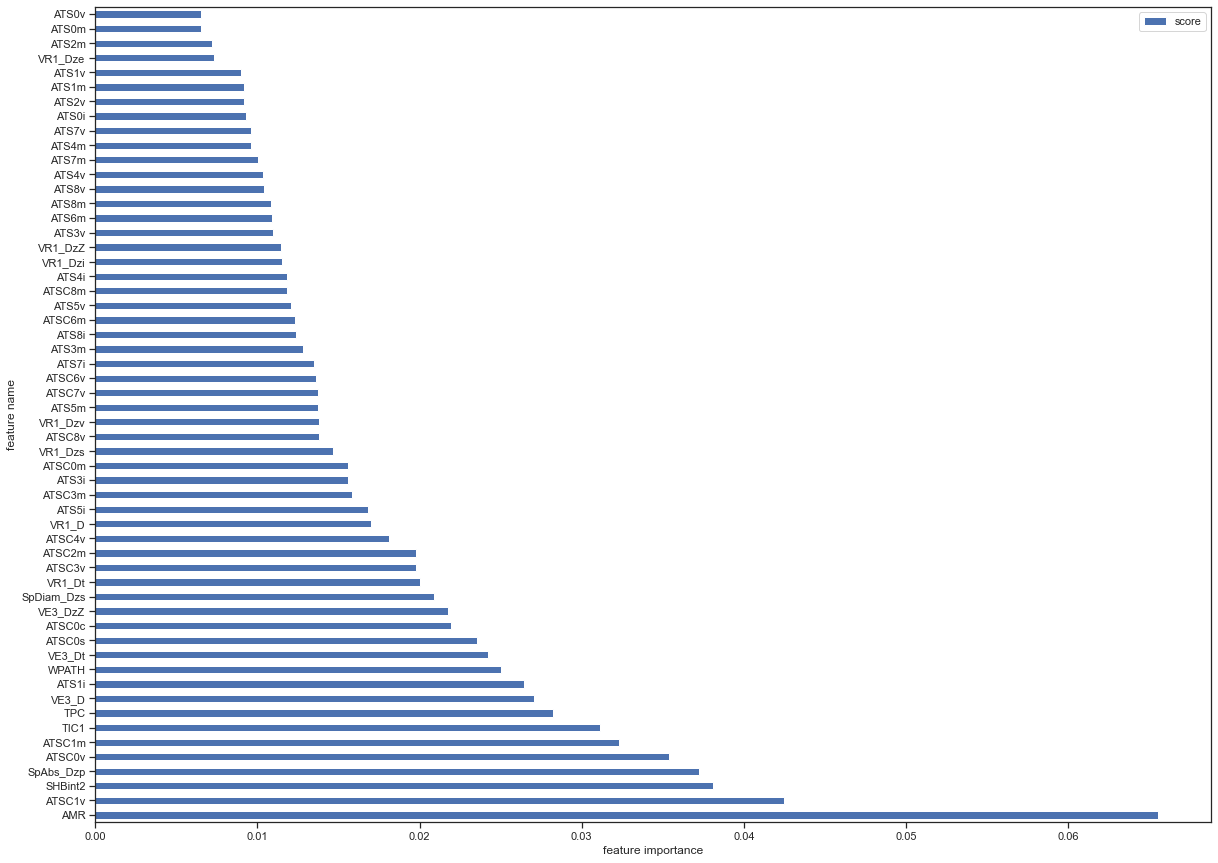

In [19]:
fig, ax = plt.subplots(figsize=(20,15))
data = pd.DataFrame(data=values, 
                    index=keys, 
                    columns=["score"]) \
        .sort_values(by = "score", ascending=False)
data.plot(kind='barh', ax=ax)
plt.xlabel('feature importance')
plt.ylabel('feature name')
plt.savefig(f'./results/img/plot_importance_with_name.png')
plt.show()


# Check some statistic of R-square

In [20]:
r2_score_of_y_test = r2_score(y_test,testans)
k  = sum(y_test*testans)/sum(y_test*y_test)
kp = sum(y_test*testans)/sum(testans*testans)
YR0p = y_test * k
YR0  = testans * kp
R20  = 1-sum((y_test-YR0)**2)/sum((y_test-y_test.mean())**2)
R20p = 1-sum((testans-YR0p)**2)/sum((testans-testans.mean())**2)
print((r2_score_of_y_test-R20p)/r2_score_of_y_test)
print((r2_score_of_y_test-R20)/r2_score_of_y_test)
Y10erro = abs(y_test-testans)
indY10erro = Y10erro.argsort()[::-1]

0.4953620052518018
-1.042143005081908e-05


# Grid Search for best results

In [21]:
%%time
xgb1 = xgb.XGBRegressor()
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
             'objective':['reg:squarederror'],
             'learning_rate': [0.05, 0.07, 0.1], #so called `eta` value
             'max_depth': [5, 6, 7,10],
             'min_child_weight': [1,4],
             'silent': [1],
             'subsample': [0.7,1],
             'colsample_bytree': [0.7,1],
             'n_estimators': [200,500],
             'reg_alpha': [0], 
             'reg_lambda':[1]}

xgb_grid = GridSearchCV(xgb1,
                       parameters,
                       scoring='r2',
                       cv = 2,
                       n_jobs = 5,
                       verbose=True)

xgb_grid.fit(Xnl10[:,regcoef[:sum(abs(reg.coef_)>0)]], 
             Y_class_10)

print(f"xgb_grid.best_score is {xgb_grid.best_score_:.5f}")
print("With paremeters:", xgb_grid.best_params_)

Fitting 2 folds for each of 192 candidates, totalling 384 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:  1.9min
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed: 10.4min
[Parallel(n_jobs=5)]: Done 384 out of 384 | elapsed: 25.0min finished


[02:34:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


xgb_grid.best_score is 0.46881
With paremeters: {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 500, 'nthread': 4, 'objective': 'reg:squarederror', 'reg_alpha': 0, 'reg_lambda': 1, 'silent': 1, 'subsample': 0.7}
Wall time: 25min 9s
